### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import hessians

### Explanations here

블록 여러개로 더 나누고 설명 적기

In [2]:
# 모델 정의
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

# 손실함수 및 최적화 함수 정의
criterion = nn.MSELoss()

In [3]:
np.random.seed()

input_dim = 20
output_dim = 1
num_samples = 1000
num_toxic_samples = 300

x = np.random.rand(num_samples, input_dim)
true_weights = np.random.rand(input_dim)
true_bias = np.random.rand() * 0
y = np.dot(x, true_weights) + true_bias

toxic_weights = np.random.rand(input_dim) * 3
toxic_bias = np.random.rand() * 0
y[:num_toxic_samples] = np.dot(x[:num_toxic_samples], toxic_weights) + toxic_bias

# Convert the data to PyTorch tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

### Optimized model for all data

In [4]:
model_1 = LinearRegression(input_dim, output_dim)
criterion_1 = nn.MSELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.1)

epochs = 1000
for epoch in range(epochs):
    y_pred = model_1(x_tensor).view(-1)
    loss = criterion_1(y_pred, y_tensor)
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()
    if (epoch+1) % 200 == 0:
        print(f'{loss =} at epoch {epoch+1}.')

print(model_1.linear.weight)

loss =tensor(12.4239, grad_fn=<MseLossBackward0>) at epoch 200.
loss =tensor(12.4231, grad_fn=<MseLossBackward0>) at epoch 400.
loss =tensor(12.4230, grad_fn=<MseLossBackward0>) at epoch 600.
loss =tensor(12.4230, grad_fn=<MseLossBackward0>) at epoch 800.
loss =tensor(12.4230, grad_fn=<MseLossBackward0>) at epoch 1000.
Parameter containing:
tensor([[ 0.6304,  0.9788,  0.8126,  1.3578,  0.2418,  0.3956,  0.9828,  1.1851,
          0.4181,  0.2447,  0.1537,  0.4199, -0.2012,  1.2139,  0.3316, -0.1582,
          0.8143,  1.1617,  0.3161, -0.3165]], requires_grad=True)


### Optimized model for desirable data

In [5]:
model_2 = LinearRegression(input_dim, output_dim)
criterion_2 = nn.MSELoss()
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [6]:
epochs = 1000
for epoch in range(epochs):
    y_pred = model_2(x_tensor[num_toxic_samples:]).view(-1)
    loss = criterion_2(y_pred, y_tensor[num_toxic_samples:])
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()
    if (epoch+1) % 200 == 0:
        print(f'{loss =} at epoch {epoch+1}.')

print(model_2.linear.weight)

loss =tensor(0.0482, grad_fn=<MseLossBackward0>) at epoch 200.
loss =tensor(0.0285, grad_fn=<MseLossBackward0>) at epoch 400.
loss =tensor(0.0176, grad_fn=<MseLossBackward0>) at epoch 600.
loss =tensor(0.0115, grad_fn=<MseLossBackward0>) at epoch 800.
loss =tensor(0.0079, grad_fn=<MseLossBackward0>) at epoch 1000.
Parameter containing:
tensor([[0.7034, 0.4509, 0.4417, 0.5045, 0.2419, 0.4087, 0.4510, 0.3997, 0.3004,
         0.5951, 0.4438, 0.5282, 0.6716, 0.4015, 0.6016, 0.3766, 0.2028, 0.2048,
         0.4330, 0.3750]], requires_grad=True)


In [7]:
model = LinearRegression(input_dim, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
bias = 1
model.linear.bias = nn.Parameter(torch.Tensor([bias]))

m1_weight =  model_1.linear.weight.view(-1).detach().tolist()
w1_values = np.arange(-5, 5, 0.5)
w2_values = np.arange(-5, 5, 0.5)
loss_values = np.zeros((len(w1_values), len(w2_values)))
for i in range(len(w1_values)):
    for j in range(len(w2_values)):
        m1_weight[0] = w1_values[i]
        m1_weight[1] = w2_values[j]
        model.linear.weight = nn.Parameter(torch.Tensor(m1_weight).unsqueeze(0))
        
        y_pred = model(x_tensor[num_toxic_samples:]).view(-1)
        loss = criterion(y_pred, y_tensor[num_toxic_samples:])
        loss_values[i][j] = loss.item()

tensor([[ 17.0740, -16.5865],
        [-16.5865,  16.2677]])
tensor([[ 3.3760, -2.4808],
        [-2.4808,  3.2884]])


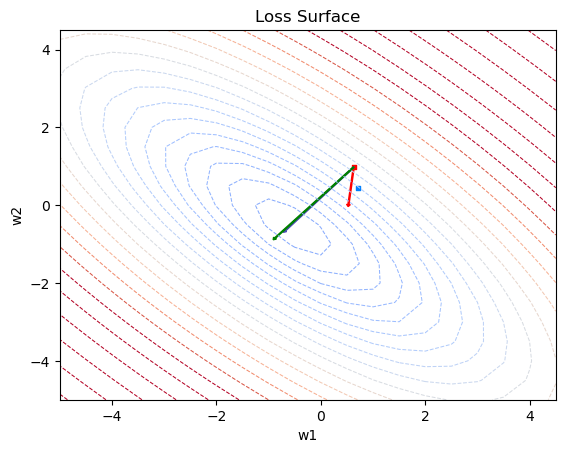

In [8]:
w = model_1.linear.weight.view(-1).detach().numpy()
y_pred = model_1(x_tensor).view(-1)
total_loss = criterion(y_pred, y_tensor)
one_loss = criterion(model_1(x_tensor[:num_toxic_samples]).view(-1), y_tensor[:num_toxic_samples])

one_gradient = hessians.compute_gradient(one_loss, model_1)
total_hessian = hessians.compute_hessian(total_loss, model_1)
index_list = [0,1]
partial_hessian = total_hessian[:, index_list]

# print("Hessian:")
# print(total_hessian)
# print("Gradient:")
# print(one_gradient, '\n')

IF = torch.inverse(total_hessian) @ one_gradient

PIF = torch.linalg.inv(partial_hessian.T @ partial_hessian)\
    @ partial_hessian.T \
    @ one_gradient /3

FIF = torch.inverse(total_hessian[:2, :2]) @ one_gradient[index_list] /3

print(torch.linalg.inv(partial_hessian.T @ partial_hessian))
print(torch.inverse(total_hessian[:2, :2]))


# 그래프 그리기
X, Y = np.meshgrid(w1_values, w2_values)
levels = np.logspace(-10, 5, 100, base=3)
cmap = plt.get_cmap('coolwarm') # colormap 지정
plt.contour(X, Y, loss_values.T, levels=levels, 
            cmap=cmap, vmin=-2, vmax=10, 
            linewidths=.75, linestyles='--')

w = model_2.linear.weight.view(-1).detach().numpy()
plt.scatter(w[0], w[1], s=5, color=(0, .5, 1), marker='s')

w = model_1.linear.weight.view(-1).detach().numpy()
plt.scatter(w[0], w[1], s=5, color=(1, 0, 0), marker='s')

# 화살표 그리기
plt.arrow(w[0], w[1], IF[0], IF[1], color='red', width=0.02, head_width=0.07, head_length=.055, length_includes_head=True)
plt.arrow(w[0], w[1], FIF[0], FIF[1], color=(.3, .3 , .7) , width=0.02, head_width=0.07, head_length=.055, length_includes_head=True)
plt.arrow(w[0], w[1], PIF[0], PIF[1], color='green', width=0.02, head_width=0.07, head_length=.055, length_includes_head=True)


plt.title("Loss Surface")
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()

In [10]:
print(total_hessian)

tensor([[0.6647, 0.5014, 0.5033, 0.4995, 0.5081, 0.5046, 0.4885, 0.4794, 0.4932,
         0.4951, 0.5078, 0.5015, 0.4898, 0.4843, 0.4964, 0.4944, 0.5138, 0.5181,
         0.4930, 0.4975, 0.9969],
        [0.5014, 0.6824, 0.5128, 0.4987, 0.5236, 0.5251, 0.5102, 0.4902, 0.5135,
         0.5117, 0.5092, 0.5085, 0.5038, 0.4958, 0.5051, 0.5173, 0.5226, 0.5209,
         0.5151, 0.5130, 1.0219],
        [0.5033, 0.5128, 0.6755, 0.5002, 0.5187, 0.5069, 0.4931, 0.4869, 0.5050,
         0.5069, 0.5040, 0.4988, 0.4947, 0.4987, 0.5030, 0.4997, 0.5187, 0.5165,
         0.4889, 0.5002, 1.0056],
        [0.4995, 0.4987, 0.5002, 0.6574, 0.4975, 0.5021, 0.4938, 0.4758, 0.4911,
         0.4910, 0.5025, 0.4888, 0.4723, 0.4788, 0.4933, 0.4966, 0.5112, 0.5040,
         0.4835, 0.4863, 0.9897],
        [0.5081, 0.5236, 0.5187, 0.4975, 0.6741, 0.5139, 0.4979, 0.4853, 0.5054,
         0.5054, 0.5131, 0.5055, 0.5022, 0.4980, 0.5064, 0.5126, 0.5251, 0.5226,
         0.5019, 0.5101, 1.0117],
        [0.5046, 0.5

In [9]:
print("Influence function")
print(IF)

print(f"Actual PIF for index {index_list}:")
print(PIF)

print(f"Freezed IF for index {index_list}:")
print(FIF)

Influence function
tensor([-0.1068, -1.0146, -0.7596, -1.3966, -0.4711,  0.1744, -1.3030, -1.6254,
        -0.0322,  0.4030,  0.3230,  0.2114,  1.5364, -1.6025,  0.2489,  0.6308,
        -0.7742, -1.1819, -0.2006,  0.8434, -2.1695])
Actual PIF for index [0, 1]:
tensor([-1.5434, -1.8675])
Freezed IF for index [0, 1]:
tensor([-1.3489, -1.6774])
